In [1]:
using Revise
using RxInfer, Random, LinearAlgebra, Distributions, Plots, StatsPlots, Flux, DelimitedFiles, StableRNGs
using ReactiveMP
using CCMP
using Base
using BenchmarkTools

In [2]:
function Base.prod(::ProdAnalytical, left::GammaShapeRate{Float64}, right::ContinuousUnivariateLogPdf)
#     rng, nr_samples, nr_iterations, optimizer = StableRNG(42), 1, 10, Flux.Adam(0.01)
#     cvi = CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 20, Val(true), true)
#     return ReactiveMP.prod(cvi, left, right)
    _, sample_friendly = ReactiveMP.logpdf_sample_friendly(left)
    # @show sample_friendly
    samples = rand(StableRNG(42), sample_friendly, 100)
    weights = pdf.(Ref(right), samples)
    # weights = weights ./ sum(weights)
    return convert(GammaShapeRate, Distributions.fit(Gamma, samples, weights))
end

In [3]:
# define CVMP forward rule
@rule DeltaFn(:out, Marginalisation) (q_ins::ReactiveMP.FactorizedJoint{P}, meta::ReactiveMP.DeltaMeta{M}) where {P <: NTuple{1}, M <: CVI} = begin
    method = ReactiveMP.getmethod(meta)
    node = getnode()
    m_out = Rocket.getrecent(ReactiveMP.messagein(node.out))
    m_ins = Rocket.getrecent.(ReactiveMP.messagein.(node.ins))

    projected_m_out = CCMP.proj(method, GammaShapeRate, getdata(m_out)) 
    
    # @show m_ins
    q_y_params = naturalparams(prod(method, getdata(m_ins[1]), projected_m_out, q_ins[1], getnodefn(Val(:out))))
    # @show q_y_params
    # @show naturalparams(projected_m_out)
    return convert(Distribution, q_y_params - naturalparams(projected_m_out))
end

<!-- ┌ Info: HERE!
└ @ Main /Users/sabinamakhmudova/repos/CVMP/demos/sunspot_gamma.ipynb:7
┌ Info: ReactiveMP.FactorizedJoint{Tuple{GammaShapeRate{Float64}}}((GammaShapeRate{Float64}(a=13605.986147431206, b=13.435354995502149),))
└ @ Main /Users/sabinamakhmudova/repos/CVMP/demos/sunspot_gamma.ipynb:8
┌ Info: (Message(Gamma{Float64}(α=1000.0, θ=1.0)),)
└ @ Main /Users/sabinamakhmudova/repos/CVMP/demos/sunspot_gamma.ipynb:9
┌ Info: Message(GammaShapeRate{Float64}(a=1.0, b=1.0))
└ @ Main /Users/sabinamakhmudova/repos/CVMP/demos/sunspot_gamma.ipynb:10
Output exceeds the size limit. Open the full output data in a text editorMethodError: no method matching prod(::ProdCVI{StableRNGs.LehmerRNG, Descent, ForwardDiffGrad, false}, ::Gamma{Float64}, ::GammaShapeRate{Float64}, ::GammaShapeRate{Float64}, ::typeof(identity))
Closest candidates are:
  prod(!Matched::ProdGeneric, ::Any, ::Any, ::Any, ::Any, !Matched::DistProduct, !Matched::DistProduct) at ~/.julia/packages/ReactiveMP/Dm45i/src/constraints/prod/prod_generic.jl:123
  prod(::ProdCVI, ::Any, ::Any) at ~/.julia/packages/ReactiveMP/Dm45i/src/approximations/cvi.jl:93
  prod(!Matched::ReactiveMP.EqualityChain, ::Any, ::Any) at ~/.julia/packages/ReactiveMP/Dm45i/src/nodes/equality.jl:78
  ... -->


In [4]:
# to check that matched with Semih
sunspot_semih = readdlm("data/SN_Akbayrak.csv")
semih_observations = map(Int, sunspot_semih[:,2]);

5 colums dataset
https://www.sidc.be/silso/infosnytot
Contents:

Column 1: Gregorian calendar year (mid-year date)

Column 2: Yearly mean total sunspot number.

Column 3: Yearly mean standard deviation of the input sunspot numbers from individual stations.

Column 4: Number of observations used to compute the yearly mean total sunspot number.

Column 5: Definitive/provisional marker. A blank indicates that the value is definitive. A '*' symbol indicates that the

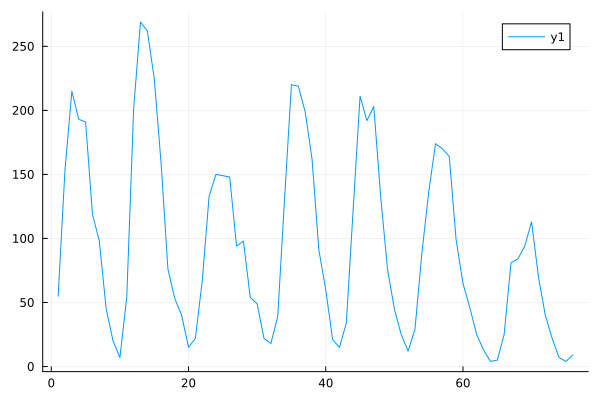

In [5]:
sunspot = readdlm("data/SN_y_tot_V2.0.csv", ';')
select_1945_2020 = filter((s) -> s[1] > 1945 && s[1] < 2021, collect(eachrow(sunspot)))
observations = map((s) -> round(s[2]), select_1945_2020)
@assert semih_observations == observations
plot(observations)


In [6]:
hello(x) = identity(x)

hello (generic function with 1 method)

In [7]:
# @meta function sunspot_meta(rng, nr_samples, nr_iterations, optimizer)
#     identity() -> CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 100, Val(true), true)
# end;

# @constraints function sunspot_constraints()
#     q(γ, z) = q(γ)q(z)
#     q(z) = q(z[begin])..q(z[end])
# end;

@model function sunspot_model(nr_observations)

    γ ~ GammaShapeRate(1000.0, 2)
    z = randomvar(nr_observations)
    y = datavar(Float64, nr_observations)
    
    # specify estimate of initial location
    z[1] ~ GammaShapeRate(1, γ)
    y[1] ~ Poisson(z[1])
    for t in 2:nr_observations
        # specify state transition model
        z[t] ~ GammaShapeRate(hello(z[t-1]), γ)
        y[t] ~ Poisson(z[t])
    end
end

@meta function sunspot_meta(rng, nr_samples, nr_iterations, optimizer)
    hello() -> CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 100, Val(true), false)
end;

@constraints function sunspot_constraints()
    q(γ, z) = q(γ)q(z)
    q(z) = q(z[begin])..q(z[end])
end;



In [14]:
# z_init = map(r -> NormalMeanPrecision(r, 10), 1:50)
nr_observations = length(observations)
CCMP.benchmark_timings[] = 0.0
@time results = inference(
    model = sunspot_model(nr_observations),
    data = (y = observations,),
    iterations = 10,
    free_energy = true,
    constraints = sunspot_constraints(),
    meta = sunspot_meta(StableRNG(42), 1, 10, Flux.Descent(0.001)),
    initmarginals = (γ=Gamma(10, 1), z=Gamma(10, 1), )
)
@show string(CCMP.benchmark_timings[] / 1e9, " sec")
results.free_energy

  0.605618 seconds (11.31 M allocations: 381.509 MiB, 10.94% gc time)
string(CCMP.benchmark_timings[] / 1.0e9, " sec") = "0.301481585 sec"


10-element Vector{Real}:
 15097.450735652803
  8033.664800943825
  6218.0935205503165
  6013.855106623651
  5990.937021863607
  5995.229344143626
  6000.392276286335
  6002.762378764725
  6002.647375334281
  6002.378298066609

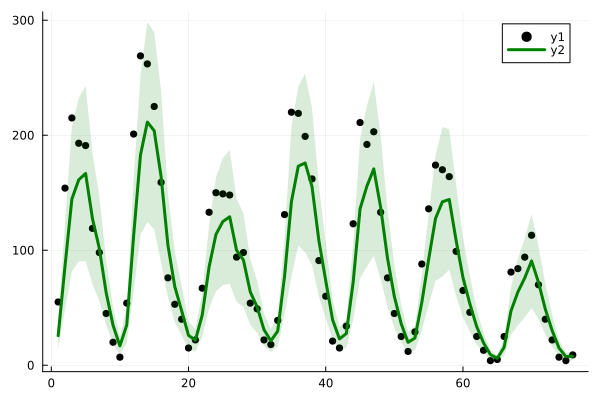

In [15]:
# plot estimates for location
posteriours = results.posteriors[:z][end]
means = map(mean, posteriours) 
ribbon = map(x -> var(x), posteriours)

p1 = scatter(observations,color=:black)

plot!(means, ribbon=ribbon, fillalpha=0.15, linewidth=3, color = :green)

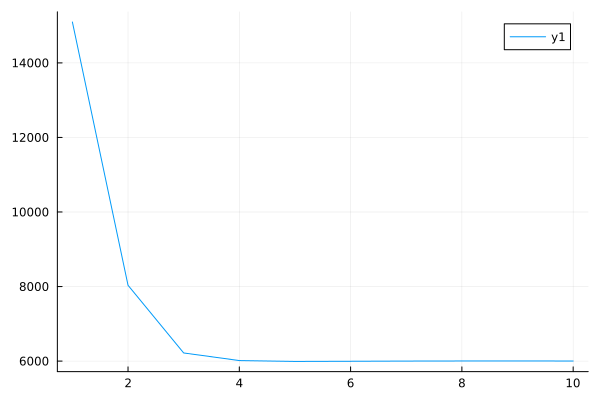

In [16]:
plot(results.free_energy[1:end])

In [18]:
@benchmark results = inference(
    model = sunspot_model(nr_observations),
    data = (y = observations,),
    iterations = 10,
    free_energy = true,
    constraints = sunspot_constraints(),
    meta = sunspot_meta(StableRNG(42), 1, 10, Flux.Descent(0.001)),
    initmarginals = (γ=Gamma(10, 1), z=Gamma(10, 1), )
)

BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  487.878 ms … 523.440 ms  ┊ GC (min … max): 5.59% … 8.04%
 Time  (median):     496.003 ms               ┊ GC (median):    5.44%
 Time  (mean ± σ):   497.965 ms ±  10.198 ms  ┊ GC (mean ± σ):  5.70% ± 0.79%

  █ ██    █ █  █  █ █    █        █                           █  
  █▁██▁▁▁▁█▁█▁▁█▁▁█▁█▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  488 ms           Histogram: frequency by time          523 ms <

 Memory estimate: 381.51 MiB, allocs estimate: 11307195.